In [5]:
!pip install xgboost --root-user-action=ignore



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install statsmodels --root-user-action=ignore


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import all you need</p>

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
color_pal = sns.color_palette()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import joblib

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [8]:
df=pd.read_csv('/kaggle/input/pjme-hourly/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">EDA</p>

In [9]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [11]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [12]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set Datetime as index
df = df.set_index('Datetime')


In [13]:
df.head(5)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Visualization</p>

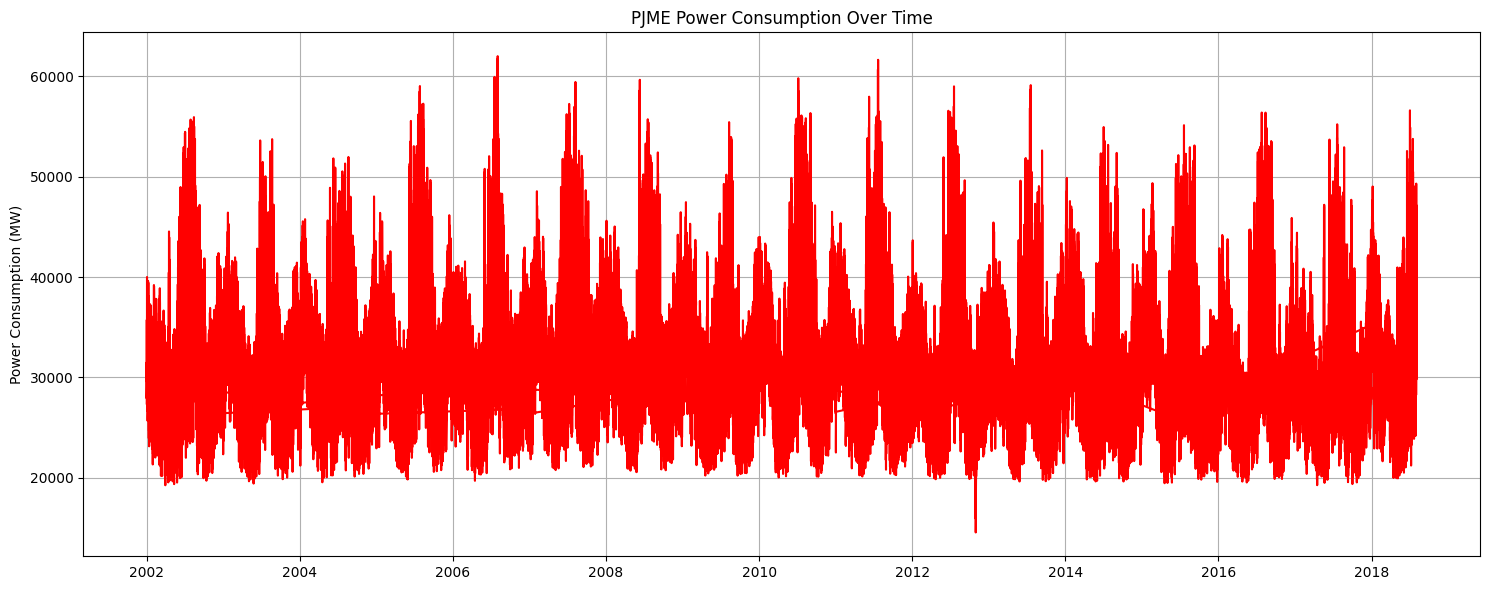

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(df['PJME_MW'],color='red')
plt.title('PJME Power Consumption Over Time')
plt.ylabel('Power Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


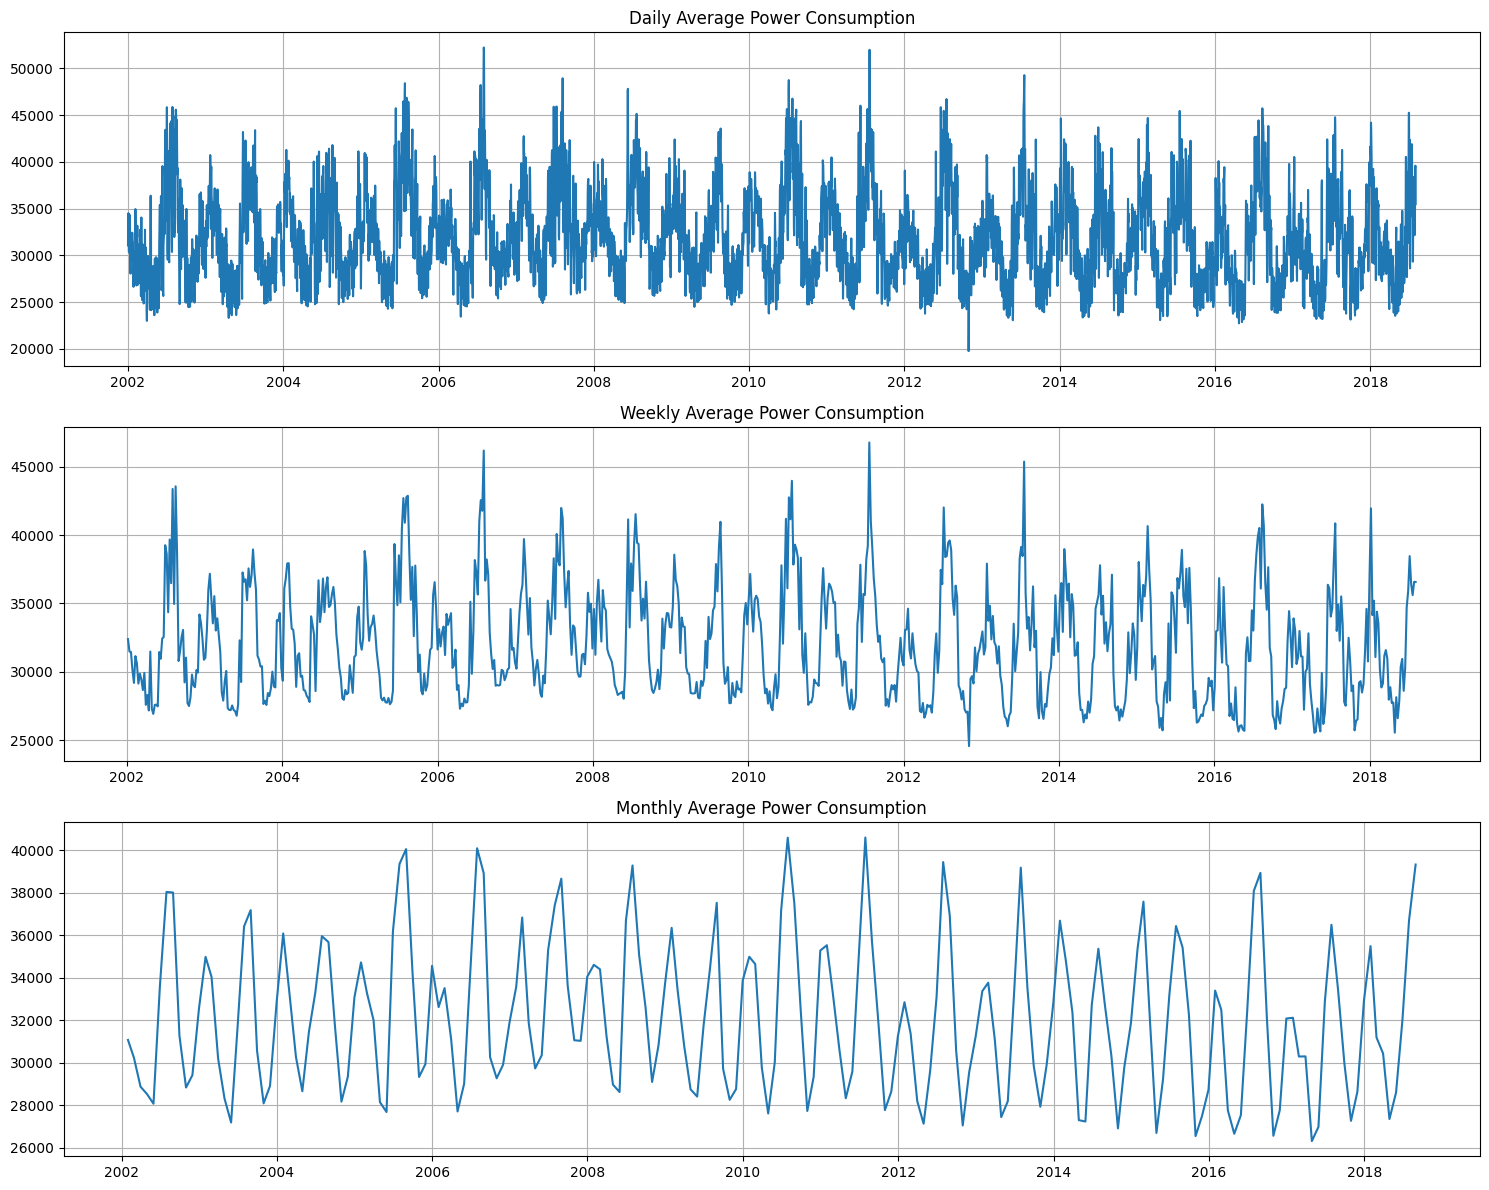

In [15]:
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()

# Plot resampled data
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].plot(df_daily)
ax[0].set_title('Daily Average Power Consumption')
ax[0].grid(True)

ax[1].plot(df_weekly)
ax[1].set_title('Weekly Average Power Consumption')
ax[1].grid(True)

ax[2].plot(df_monthly)
ax[2].set_title('Monthly Average Power Consumption')
ax[2].grid(True)

plt.tight_layout()
plt.show()



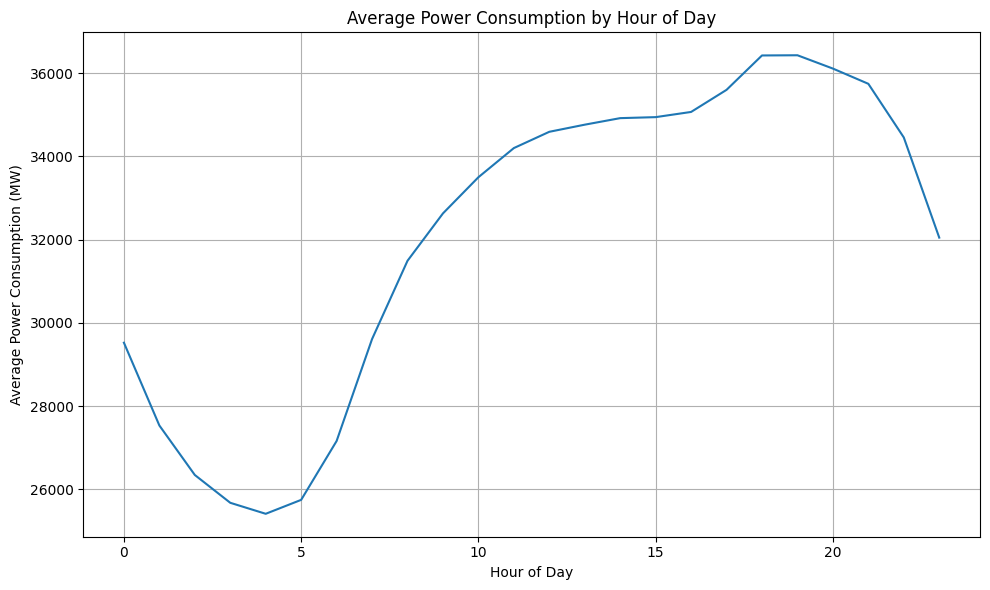

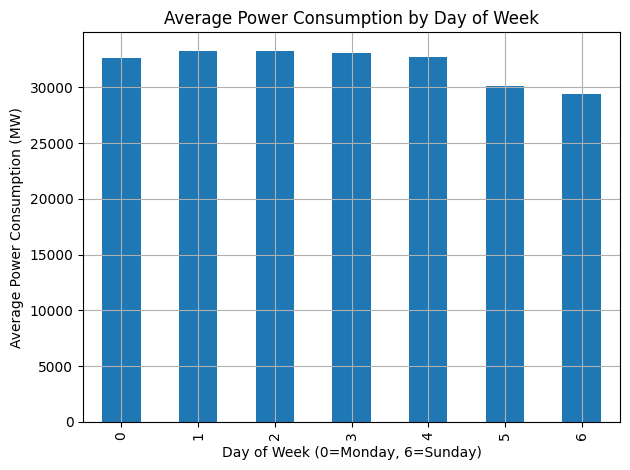

In [16]:
daily_data = df['PJME_MW'].resample('H').mean()
daily_data = daily_data.groupby([daily_data.index.hour]).mean()
weekly_data = df['PJME_MW'].resample('D').mean()
weekly_data = weekly_data.groupby([weekly_data.index.dayofweek]).mean()


plt.figure(figsize=(10, 6))
daily_data.plot()
plt.title('Average Power Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

weekly_data.plot(kind='bar')
plt.title('Average Power Consumption by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Power Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()



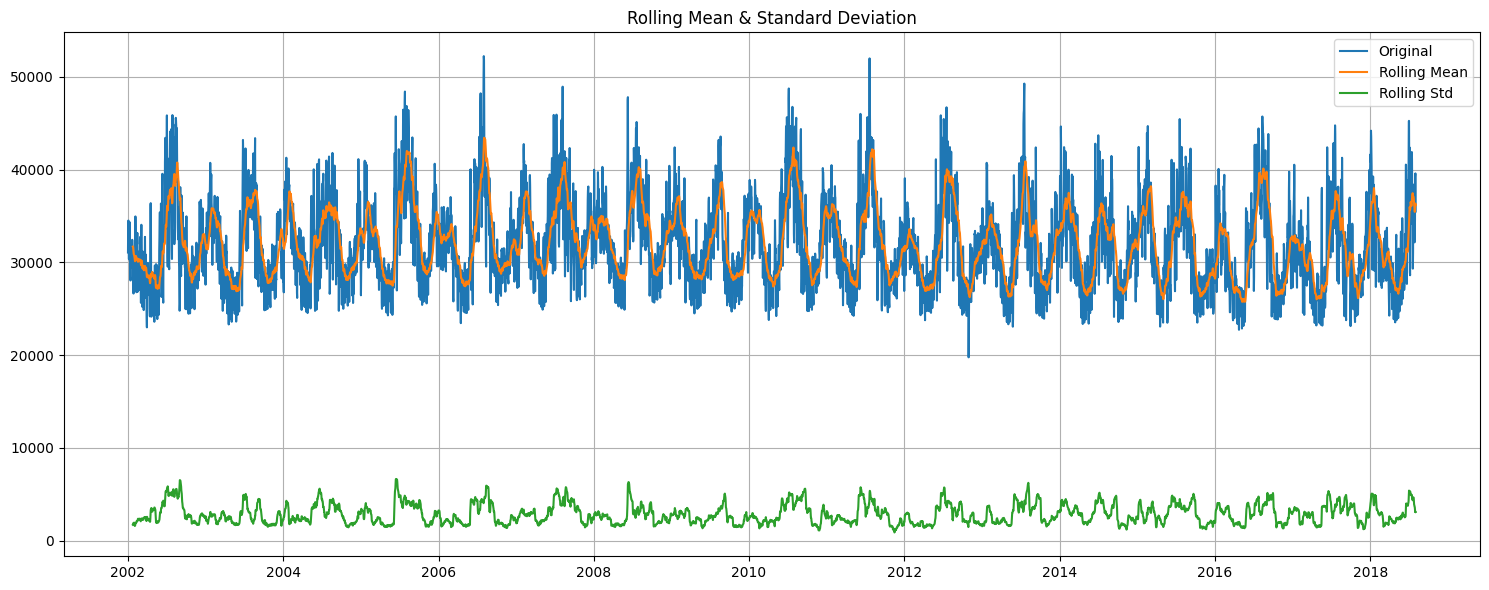

Results of Dickey-Fuller Test:
Test Statistic                -8.262177e+00
p-value                        5.048772e-13
#Lags Used                     3.400000e+01
Number of Observations Used    6.024000e+03
Critical Value (1%)           -3.431436e+00
Critical Value (5%)           -2.862020e+00
Critical Value (10%)          -2.567025e+00
dtype: float64


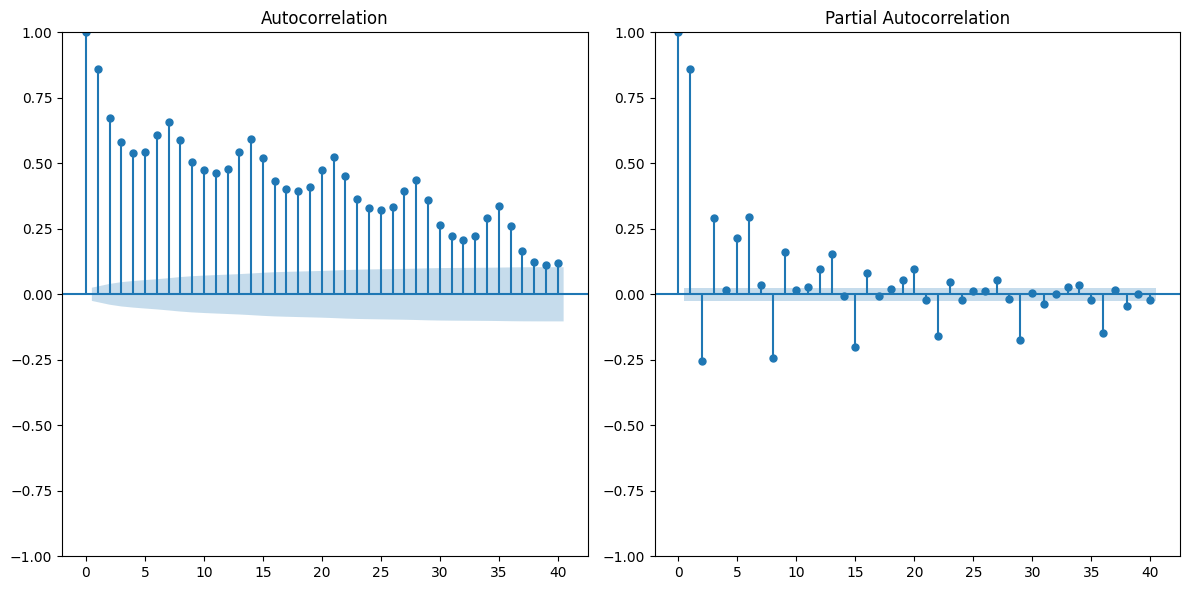

In [17]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(15, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Check stationarity on daily data
check_stationarity(df_daily['PJME_MW'])

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(df_daily['PJME_MW'].dropna(), lags=40, ax=plt.subplot(121))
plot_pacf(df_daily['PJME_MW'].dropna(), lags=40, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Preprocessing </p>

In [29]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Add lag features
    
    
    return df

# Create features
df_features = create_features(df)

# Handle missing values created by lag features
df_features = df_features.dropna()


In [30]:
df_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


In [31]:
features = [col for col in df_features.columns if col != 'PJME_MW']

scaler = MinMaxScaler()

df_features[features] = scaler.fit_transform(df_features[features])


In [32]:
X=df_features.drop(columns='PJME_MW')
y=df_features['PJME_MW']

In [54]:
test_split_date = df_features.index.max() - pd.Timedelta(days=30)
val_split_date = test_split_date - pd.Timedelta(days=30)

train_data = df_features[df_features.index <= val_split_date]
val_data = df_features[(df_features.index > val_split_date) & (df_features.index <= test_split_date)]
test_data = df_features[df_features.index > test_split_date]
X_val, y_val = val_data[features], val_data['PJME_MW']


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model building</p>

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=1000,            # Number of boosting trees
    learning_rate=0.01,            # Step size shrinkage
    max_depth=4,                   # Max tree depth
    subsample=0.8,                 # Subsample ratio of training instances
    colsample_bytree=0.8,          # Subsample ratio of columns
    reg_alpha=0.1,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

MAE: 2161.8062501209197
MSE: 8694871.233374126
RMSE: 2948.706705214021
R²: 0.789134250225315


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

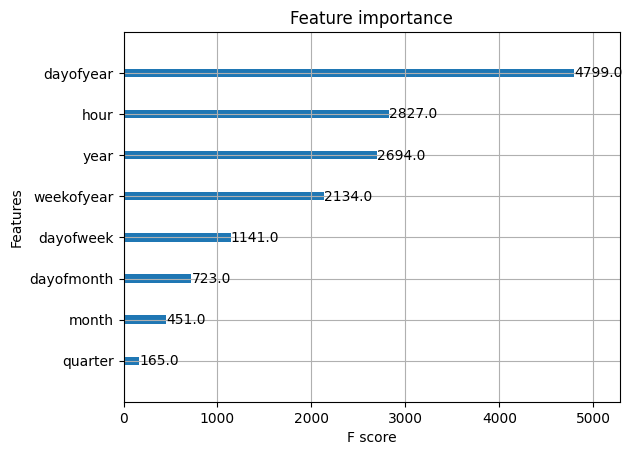

In [35]:
xgb.plot_importance(model)

In [56]:
def tune_xgboost_model(X_train, y_train, X_val, y_val):
    print("Tuning XGBoost hyperparameters...")
    
    # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0.1, 0.5, 1, 5]
    }
    
    # Initialize XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Setup time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=50,  # Number of parameter settings sampled
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Get best parameters and score
    print("\nBest Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
    
    print(f"\nBest RMSE: {-random_search.best_score_:.2f}")
    
    # Train model with best parameters
    best_xgb_model = xgb.XGBRegressor(**random_search.best_params_, random_state=42)
    best_xgb_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_predictions = best_xgb_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    y_pred = best_xgb_model.predict(X_test)
    
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"R²: {r2_score(y_test, y_pred)}")
    
    # Feature importance
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(best_xgb_model, max_num_features=15)
    plt.title('Tuned XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_xgb_model, random_search.best_params_


Tuning XGBoost hyperparameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters:
subsample: 0.8
reg_lambda: 5
reg_alpha: 0.1
n_estimators: 500
min_child_weight: 1
max_depth: 9
learning_rate: 0.2
gamma: 0.2
colsample_bytree: 0.8

Best RMSE: 1023.40
MAE: 494.52051886323477
MSE: 445975.48243390705
RMSE: 667.8139579507956
R²: 0.9891843188978361


<Figure size 1200x600 with 0 Axes>

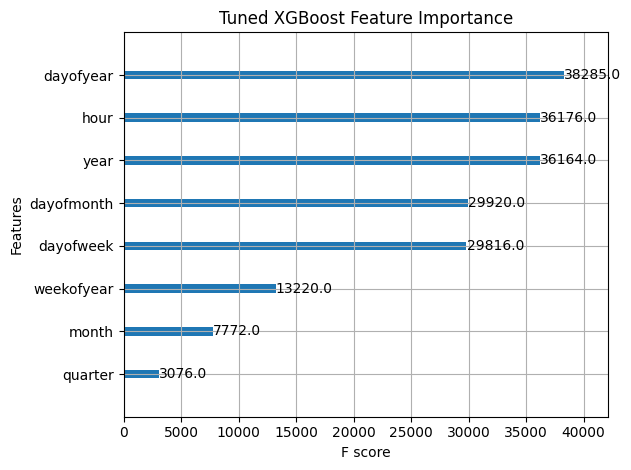

In [57]:
best_model, best_params = tune_xgboost_model(X_train, y_train, X_val, y_val)

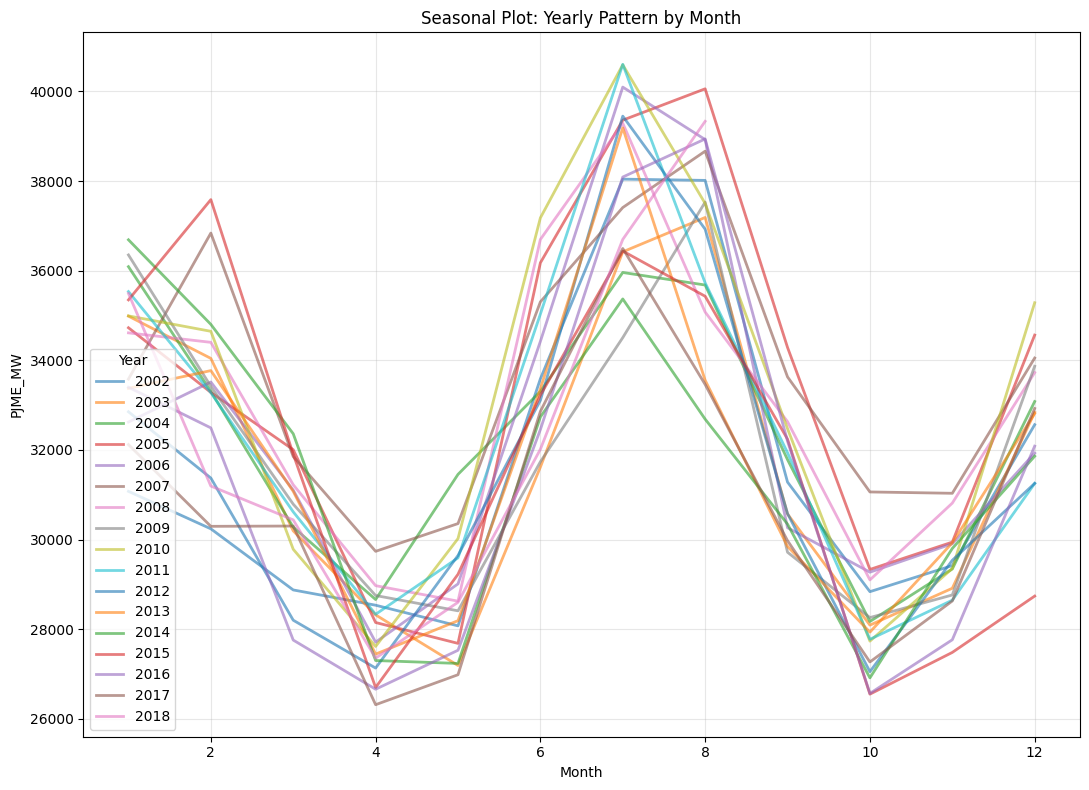

In [92]:
X = df.copy()

X['month'] = df.index.month
X['year'] = df.index.year
X['dayofyear'] = df.index.dayofyear
X['dayofmonth'] = df.index.day
X['weekofyear'] = df.index.isocalendar().week

# Create plots
fig= plt.subplots(figsize=(11, 8))
seasonal_plot(X, y="PJME_MW", period="year", freq="month")
plt.tight_layout()
plt.show()


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">save best model</p>

In [60]:
joblib.dump(best_model,'pre_Energy.joblib')

['pre_Energy.joblib']